<a href="https://colab.research.google.com/github/Pavansyamala/GenerativeAdverserialNN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot as plt

In [2]:
(train_x , train_y) , (test_x,test_y) = load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
train = train_x.copy()

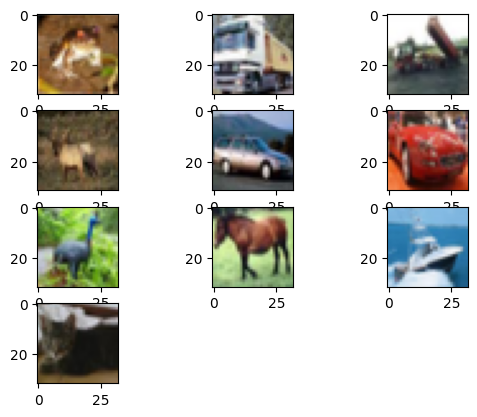

In [4]:
for i in range(10):
  plt.subplot(4,3,i+1)
  plt.imshow(train_x[i])
plt.show()

In [5]:
from keras.models import Sequential
from keras.layers import Dense , Conv2D , Flatten , Dropout , LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

In [6]:
import numpy as np

In [7]:
def define_descriminator(input_shape = (32,32,3)):

  model = Sequential()

  model.add(Conv2D(64 , (3,3) , padding = 'same' , input_shape = input_shape))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(256,(3,3),strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Flatten())

  model.add(Dropout(0.4))

  model.add(Dense(1,activation = 'sigmoid'))

  opt = Adam(lr = 0.002 , beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy' , optimizer = opt , metrics = ['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         2

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


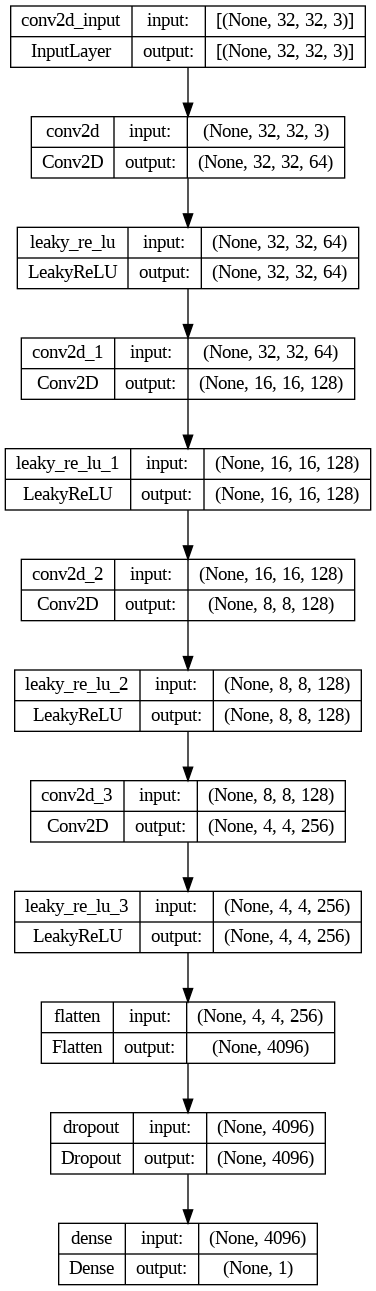

In [8]:
model = define_descriminator()
model.summary()
plot_model(model , to_file = 'discriminator_plot.png' , show_shapes = True , show_layer_names = True)

In [9]:
def load_real_sample():

  (train_x,_),(_,_) = load_data()
  x = train_x.astype('float32')

  x = (x-127.5)/127.5

  return x

In [10]:
def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0] , n_samples)

  x = dataset[ix]

  y = np.ones((n_samples , 1))

  return x , y

In [11]:
dataset = load_real_sample()

x,y = generate_real_samples(dataset , 64)

In [12]:
def generate_fake_samples(n_samples):
  x = np.random.rand(32*32*3*n_samples)
  x = -1 + x*2
  x = x.reshape((n_samples , 32,32,3))
  y = np.zeros((n_samples,1))
  return x , y

In [13]:
fake_x , fake_y = generate_fake_samples(64)

In [14]:
def train_descriminator(model , dataset , n_iteration = 20 , n_batch = 128):

  half_batch = int(n_batch/2)

  for i in range(n_iteration):
    x_real , y_real = generate_real_samples(dataset , half_batch)

    _ , train_acc = model.train_on_batch(x_real , y_real)

    x_fake , y_fake = generate_fake_samples( half_batch)

    _ , train_acc_fake = model.train_on_batch(x_fake , y_fake)

    print(f'{i+1} iteration real accuracy {train_acc} and fake accuracy {train_acc_fake}')

In [15]:
model = define_descriminator()

dataset = load_real_sample()

train_descriminator(model , dataset)

1 iteration real accuracy 0.71875 and fake accuracy 0.0
2 iteration real accuracy 0.015625 and fake accuracy 0.0
3 iteration real accuracy 0.90625 and fake accuracy 0.859375
4 iteration real accuracy 0.9375 and fake accuracy 0.984375
5 iteration real accuracy 0.96875 and fake accuracy 1.0
6 iteration real accuracy 0.953125 and fake accuracy 1.0
7 iteration real accuracy 1.0 and fake accuracy 1.0
8 iteration real accuracy 1.0 and fake accuracy 1.0
9 iteration real accuracy 1.0 and fake accuracy 1.0
10 iteration real accuracy 1.0 and fake accuracy 1.0
11 iteration real accuracy 1.0 and fake accuracy 1.0
12 iteration real accuracy 1.0 and fake accuracy 1.0
13 iteration real accuracy 1.0 and fake accuracy 1.0
14 iteration real accuracy 1.0 and fake accuracy 1.0
15 iteration real accuracy 1.0 and fake accuracy 1.0
16 iteration real accuracy 1.0 and fake accuracy 1.0
17 iteration real accuracy 1.0 and fake accuracy 1.0
18 iteration real accuracy 1.0 and fake accuracy 1.0
19 iteration real ac

In [16]:
from keras.models import Sequential
from keras.layers import Dense , Conv2D , Flatten , Dropout , LeakyReLU , Conv2DTranspose , Reshape
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam

In [17]:
def define_generator(latent_dim):
  model = Sequential()
  # foundation_for 4*4 image
  n_nodes = 256*4*4

  model.add(Dense(n_nodes , input_dim = latent_dim))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((4,4,256)))

  # Up sample to 8*8
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Up sample to 16*16
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Up Sample to 32 * 32
  model.add(Conv2DTranspose(128 , (4,4) , strides = (2,2) , padding = 'same'))
  model.add(LeakyReLU(0.2))

  # Output Layer

  model.add(Conv2D(3 , (3,3) , activation = 'tanh' , padding = 'same'))

  return model


In [19]:
gen_model = define_generator(100)

In [20]:
gen_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

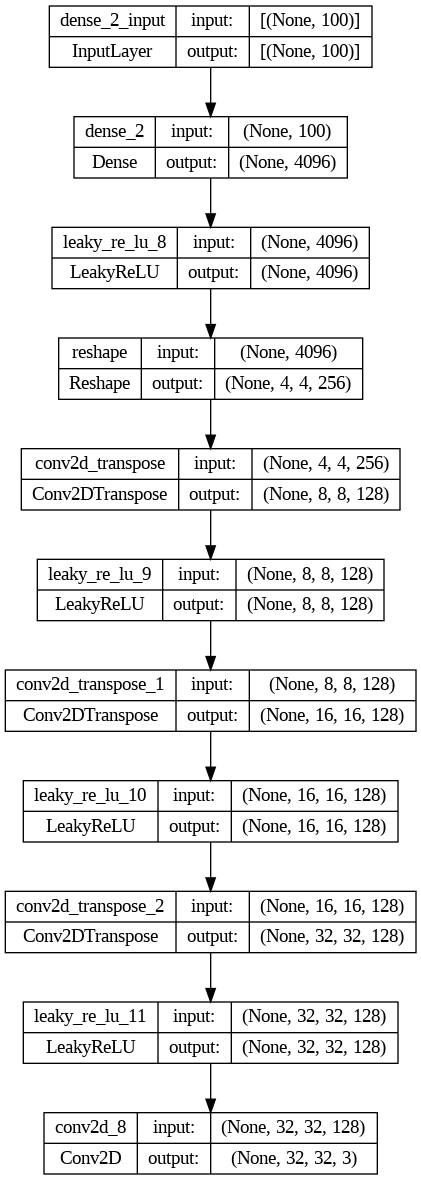

In [21]:
plot_model(gen_model , 'gen_model.png' , show_shapes = True , show_layer_names=True)

In [22]:
def generate_latent_points(latent_dim , n_samples):
  x = np.random.rand(latent_dim*n_samples)
  x = x.reshape((n_samples , latent_dim))
  return x

In [30]:
def generate_fake_samples(g_model , latent_dim , n_samples):

   x_input = generate_latent_points( latent_dim , n_samples)
   y = np.zeros((n_samples , 1))
   return g_model.predict(x_input) , y

In [25]:
g_model = define_generator(100)

In [31]:
fake_sample , label = generate_fake_samples(g_model , 100 , 64)

2/2 [==============================] - 0s 179ms/step


In [32]:
## Define Combined Generator and Discriminator Model for Generator Training

In [35]:
def define_gan(g_model , d_model):

  # Setting Discriminator model weight Updations False
  d_model.trainable = False

  model = Sequential()
  model.add(g_model)
  model.add(d_model)

  opt = Adam(lr = 0.0002 , beta_1 = 0.5)
  model.compile(optimizer = opt , loss = 'binary_crossentropy')

  return model

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 32, 32, 3)         1466115   
                                                                 
 sequential_13 (Sequential)  (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


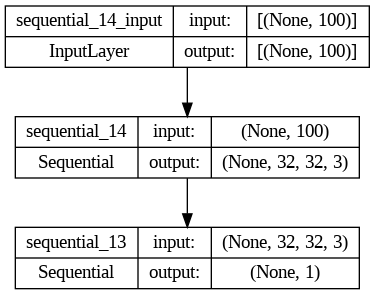

In [38]:
latent_dim = 100
d_model = define_descriminator()
g_model = define_generator(latent_dim)

gan = define_gan(g_model , d_model)

gan.summary()

plot_model(gan , to_file = 'GAN_plot.png' , show_shapes = True , show_layer_names = True)

In [39]:
def train(g_model , d_model , gan_model , dataset , latent_dim , n_epochs = 200 , n_batch = 128):
  batch_per_epoch = int(dataset/n_batch)
  half_batch = int(n_batch/2)

  for i in range(n_epochs) :
    for j in range(batch_per_epoch):
      x_real , y_real = generate_real_samples(dataset , half_batch)
      dloss1 , _ = d_model.train_on_batch(x_real , y_real)
      x_fake , y_fake = generate_fake_samples(g_model , latent_dim)
      dloss2 , _ = d_model.train_on_batch(x_fake , y_fake)

      x_gan = generate_latent_points(latent_dim , half_batch)
      y_gan = np.ones((n_batch , 1))

      gloss1 = gan_model.train_on_batch(x_gan , y_gan)

      print(f'{i+1} , {j+1} , batch-per-epoch{batch_per_epoch} , d-loss1 {dloss1} , d-loss2 {dloss2} , g-loss1 {gloss1}')

      if (i+1)%10 == 0 :
        summarize_performance(i , g_model , d_model , dataset , latent_dim , n_samples = 150)

In [41]:
def summarize_performance(epoch , g_model , d_model , dataset , latent_dim , n_samples) :

  x_real , y_real = generate_real_samples(dataset ,n_samples)
  _ , acc_real = d_model.evaluate(x_real , y_real , verbose = 0)

  x_fake , y_fake = generate_fake_samples(g_model , n_samples)
  _ , acc_fake = d_model.evaluate(x_fake , y_fake , verbose = 0)

  print(f'Accuracy real {acc_real} and Fake Accuracy is {acc_fake} of discriminator model after {i+1} epoch')

  save_plot(x_fake , epoch)

  file_name = 'generator_model_%03d.hs'%(epoch+1)
  g_model.save(file_name)

In [40]:
def save_plot(fake_x , epoch , n=7):

  fake_x = (fake_x + 1)/2

  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.axis('off')
    plt.imshow(fake_x[i])

  file_name = 'plot_e%03d.png'%(epoch+1)
  plt.savefig(file_name)
  plt.close()